The aim of the notebook is to be able to use tensorflow for building NN. 


In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from time import time
import tensorflow as tf
% matplotlib inline

#import tensorflow as tf
import collections
np.random.seed(seed=8723)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


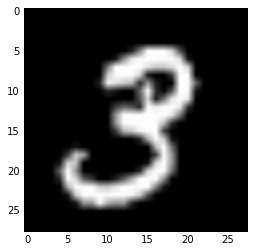

In [4]:
test = mnist.train.images[1]
plt.imshow(test.reshape(28,28),cmap=plt.cm.gray)

The first pratice is to use softmax regression to perform digit classification. The input is flattened handwritten digits. The output is probability of it belonging to a certain digit class. The netinput will be converted into probability of being a certain digit. And the error will be used for gradient descent. A softmax includes two steps, 1st, we add up the evidence of our input being in certain classes. Next, we convert the evidence into probabilities

Create placeholder for values that perform symbolic computation. 'None' indicates any number of sample inputs. 

In [7]:
x = tf.placeholder(tf.float32, [None,784])

We also need to creat weights and biases for the model. Instead of treating them as extra inputs to the graph, we treat weights and biases as modifiable variable that lives in the graph. For machine learning, we normally have parameter as variables


In [13]:
W = tf.Variable(tf.zeros([784,10]))
b =  tf.Variable(tf.zeros([10]))

To be able to assess teh linear regression methods for digit recognition, we first calculted the weighted sum of the input and weights as well as  biases. Our goal is to make the output as probabiltiy of the input being each digit. One way to implement is by exponentiate the net input and normalize across each output. These two steps are called softmax

$netinput_{i} = \sum_{j} x_{j}w_{i,j} + b$

$y_{i} = exp^{netinput_{i}}/\sum_{i} exp^{netinput_{i}} $

In [14]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

Next step, we need to train the model. First, we need a criteria to say whether the model is good, which means that we need to define the cost function. One common way to define the loss is known as cross-entropy. 

$H_{y'}(y) = - \sum_i y'_{i} log(y_{i})$

First, we need to give place holder for correct answer

In [15]:
y_ = tf.placeholder(tf.float32, [None, 10])

In [19]:
cross_entropy = tf.reduce_mean(- tf.reduce_sum(y_ * tf.log(y), reduction_indices = [1]))

Given that tensorflow knows the entire graph, it can perform automatically the gradient descent based on cost function. And that performs the training step

In [20]:
train_step  = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

Here, tensorflow use gradientdescent method to train the model with 0.5 learning rate.

To train the model, we need to initialize it first

In [22]:
init = tf.initialize_all_variables()

In [24]:
sess = tf.Session()
sess.run(init)

In [49]:
for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict = {x: batch_xs, y_: batch_ys})

In [50]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict = {x: mnist.test.images, y_: mnist.test.labels}))

0.9214


#### The above gives an example on how to run tensorflow to perform MNIST categorization. However, the basic concept is not quite clear. Here, we made use of Oreilly's tutorial to obtain a general understanding of the difference between python and tensorflow as well as the big picture how to use tensorflow for different tasks. We will also use tensorboard to have a visualization of the graph that we build.

Tensorflow is built up on the idea of graphs. Instead of realizing a certain computation once it is defined, tensorflow seperate the computation into graphs and real computation. We could think of graph as blueprint, and each computation, performed by session as construction site.

Once we import tensorflow using

In [1]:
import tensorflow as tf

We already have a default graph that is empty.

In [2]:
graph = tf.get_default_graph()

The nodes in tensorflow graphs are called "operations" or "ops". We could see what operations are in the graph with

In [3]:
graph.get_operations()

[]

As mentioned before, currently we only have the default empty graph. We will need to put everything we want tensorflow to compute into the graph with the format that tensorflow could understand.

We could start from a simple constant input value of one

In [4]:
input_value = tf.constant(1.0)

In [5]:
operations = graph.get_operations()
operations

In [6]:
operations[0].node_def

name: "Const"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_FLOAT
      tensor_shape {
      }
      float_val: 1.0
    }
  }
}

Tensorflow uses protocol buffers internally. By using node_def, we could visualize the protocol buffer.

Importantly, the above defination does not give value to input_value

In [7]:
input_value

<tf.Tensor 'Const:0' shape=() dtype=float32>

If we want to give value to input_value, we have to run the sesseion

In [8]:
sess = tf.Session()
sess.run(input_value)

1.0

We have tried using tf.constant() to obtain an input value. In tensorflow, input value normally is not constant. It changes with different input coming. Therefore, tf.placeholder is freqently used to constrain the datatype and dimension of the input while leave the exat number to be determined.

A different type of value in tensorflow is called variables. Variable in tensorflow graph could be understood as parameters of neural network. They don't have placeholder. Instead, they could be updated.

In [9]:
weight = tf.Variable(0.8)

Here, we could try a simple updating scheme on weights and add one for each iteration.

In [10]:
for op in graph.get_operations():print(op.name)

Const
Variable/initial_value
Variable
Variable/Assign
Variable/read


In [11]:
output_value = input_value * weight

In [12]:
op = graph.get_operations()[-1]
op.name

'mul'

In [13]:
for op_input in op.inputs: print(op_input)

Tensor("Const:0", shape=(), dtype=float32)
Tensor("Variable/read:0", shape=(), dtype=float32)


The above shows how the multiplication operation tracks where its inputs come from: they come from other operations in the graph. To understand a whole graph, we will need to make sure of tensorboard

To be able to find the product value, we will need to run the output_value operation, which depends on a variable: weight. We told Tensorflow that the intial value of weight should be 0.8. But the value hasn't been set yet in the current session.

Remember, variables has to be intialized before using session to run the operations related to it. 

In [17]:
init = tf.initialize_all_variables()
sess.run(init)

In [18]:
sess.run(output_value)

0.80000001

### See the graph in tensorboard

Tensorboard reads the name field that is stored inside each operation. 

In [19]:
x = tf.constant(1.0, name = 'input')
w = tf.Variable(0.8, name = 'weight')
y = tf.mul(w, x, name = 'output')

TensorBoard works by looking at a directory of output created from Tensorflow sessions. We need to write the output with a SummaryWriter.

In [20]:
summary_writer =tf.train.SummaryWriter('log_simple_graph', sess.graph)

Now, at the command line, we could start up the Tensorboard

In [22]:
$ tensorboard --logdir=log_simple_graph

SyntaxError: invalid syntax (<ipython-input-22-24fdad090302>, line 1)